<a href="https://colab.research.google.com/github/saramith/Human-Face-Generation-using-GAN/blob/main/GAN_for_human_face_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# Configure Kaggle API credentials
!mkdir -p ~/.kaggle
!echo '{"username":"sarayumiththira","key":"46d741395223280eabe516687df11b17"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
amanbarthwal/imdb-movies-data                                       IMDB Movies Dataset                                   8MB  2024-05-16 18:43:48           1641         28  1.0              
prasad22/weather-data                                               Weather Data                                         43MB  2024-05-18 14:27:35           1048         24  1.0              
jainaru/electric-vehicle-population                                 Electric Vehicle Data                                 6MB  2024-05-21 18:40:16            792         25  1.0              
rahulvyasm/netflix-movies-and-tv-shows  

In [ ]:
! kaggle datasets download -d farzadnekouei/50k-celebrity-faces-image-dataset

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/50k-celebrity-faces-image-dataset
License(s): unknown
100% 332M/333M [00:18<00:00, 22.0MB/s]
100% 333M/333M [00:18<00:00, 19.3MB/s]


In [ ]:
! unzip 50k-celebrity-faces-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Celebrity_Faces_Dataset/045001.jpg  
  inflating: Celebrity_Faces_Dataset/045002.jpg  
  inflating: Celebrity_Faces_Dataset/045003.jpg  
  inflating: Celebrity_Faces_Dataset/045004.jpg  
  inflating: Celebrity_Faces_Dataset/045005.jpg  
  inflating: Celebrity_Faces_Dataset/045006.jpg  
  inflating: Celebrity_Faces_Dataset/045007.jpg  
  inflating: Celebrity_Faces_Dataset/045008.jpg  
  inflating: Celebrity_Faces_Dataset/045009.jpg  
  inflating: Celebrity_Faces_Dataset/045010.jpg  
  inflating: Celebrity_Faces_Dataset/045011.jpg  
  inflating: Celebrity_Faces_Dataset/045012.jpg  
  inflating: Celebrity_Faces_Dataset/045013.jpg  
  inflating: Celebrity_Faces_Dataset/045014.jpg  
  inflating: Celebrity_Faces_Dataset/045015.jpg  
  inflating: Celebrity_Faces_Dataset/045016.jpg  
  inflating: Celebrity_Faces_Dataset/045017.jpg  
  inflating: Celebrity_Faces_Dataset/045018.jpg  
  inflating: Celebrity_Faces_Dataset/045019.jpg  

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import BatchNormalization, Dropout, Reshape, Flatten

In [ ]:
# Get a list of all image paths in the directory
image_paths = glob.glob('/content/Celebrity_Faces_Dataset/*.jpg')

# Considering only the first 20,000 images
image_paths = image_paths[:20000]

# Create a function to open, crop and resize images
def load_and_preprocess_real_images(image_path, target_size=(64, 64)):
    # Open the image
    img = Image.open(image_path)
    # Crop 20 pixels from the top and bottom to make it square
    img = img.crop((0, 20, 178, 198))
    # Resize the image
    img = img.resize(target_size)
    # Convert to numpy array and scale to [-1, 1]
    img = np.array(img)/127.5 - 1
    return img

# Open, crop and resize all images
dataset = np.array([load_and_preprocess_real_images(img_path) for img_path in image_paths])

# Print dataset shape
print(dataset.shape)

(20000, 64, 64, 3)


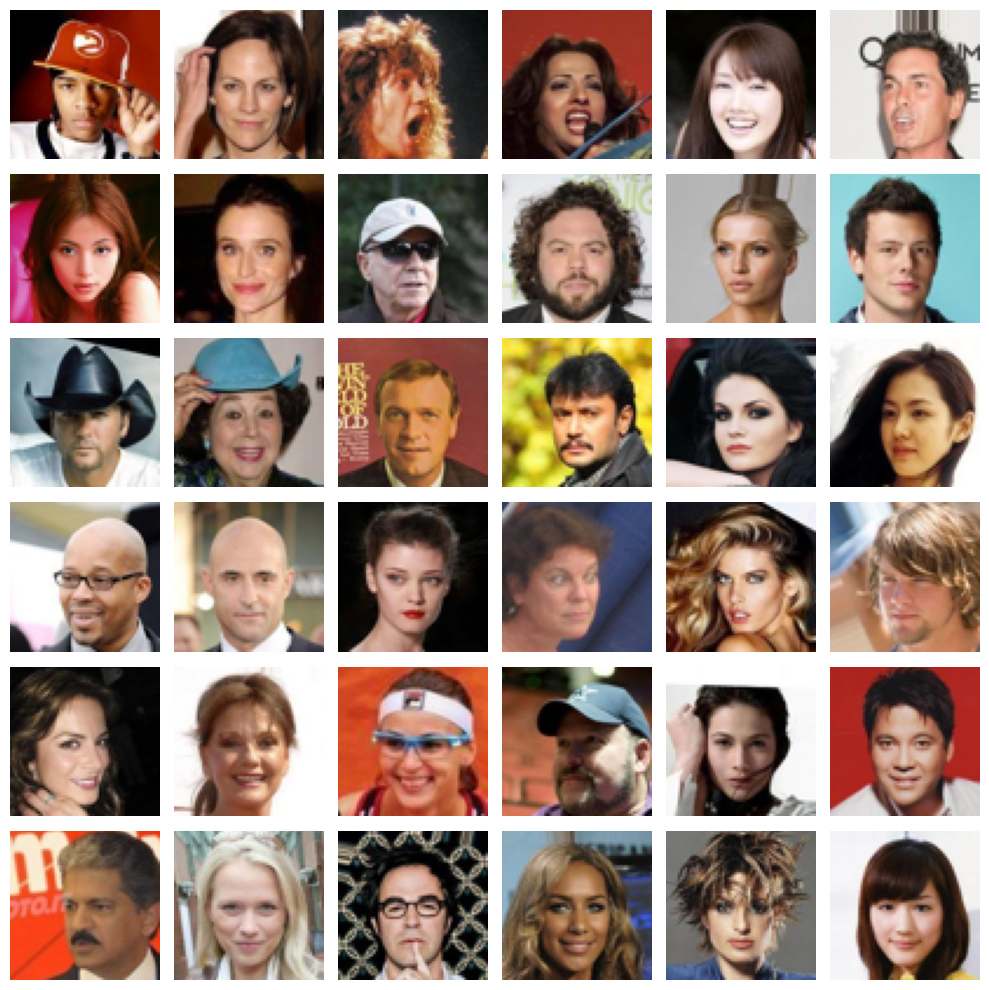

In [ ]:
# Create a figure with a specified size
plt.figure(figsize=(10, 10))

# Loop through each subplot index
for i in range(36):  # 6 * 6 = 36
    # Get the i-th image
    img = dataset[i]
    # Rescale the image to [0, 1] for plotting
    img_rescaled = (img + 1) / 2
    # Create a subplot
    plt.subplot(6, 6, i + 1)
    # Plot the image on the i-th subplot
    plt.imshow(img_rescaled)
    # Remove the axis
    plt.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
def build_discriminator(image_shape=(64, 64, 3)):
    model = Sequential()

    # Initial convolutional layer
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(0.2))

    # Second convolutional layer
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))

    # Third convolutional layer
    model.add(Conv2D(256, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))

    # Fourth convolutional layer
    model.add(Conv2D(256, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))

    # Fifth convolutional layer
    model.add(Conv2D(512, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))

    # Flatten and dense layer for classification
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # Define optimizer and compile model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Build and display discriminator summary
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         5

In [ ]:
def build_generator(latent_dim, channels=3):
    model = Sequential()

    # Initial dense layer
    model.add(Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))

    # Reshape to (16, 16, 128) tensor for convolutional layers
    model.add(Reshape((16, 16, 128)))

    # First deconvolutional layer
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))

    # Second deconvolutional layer
    model.add(Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(0.2))

    # Third deconvolutional layer
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))

    # Fourth deconvolutional layer
    model.add(Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(0.2))

    # Output convolutional layer with 'tanh' activation
    model.add(Conv2D(channels, (8, 8), activation='tanh', padding='same'))

    return model

# Build and display generator summary
generator = build_generator(100)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             3309568   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                           

In [ ]:
def build_gan(generator, discriminator):

    # Setting discriminator as non-trainable, so its weights won't update when training the GAN
    discriminator.trainable = False

    # Creating the GAN model
    model = Sequential()

    # Adding the generator
    model.add(generator)

    # Adding the discriminator
    model.add(discriminator)

    # Compiling the GAN model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
def generate_real_samples(dataset, num_samples):
    sample_indices = randint(0, dataset.shape[0], num_samples)
    X = dataset[sample_indices]
    y = ones((num_samples, 1))
    return X, y

In [ ]:
def generate_noise_samples(num_samples, noise_dim):
    X_noise = randn(noise_dim * num_samples)
    X_noise = X_noise.reshape(num_samples, noise_dim)
    return X_noise

In [ ]:
def generate_fake_samples(generator, noise_dim, num_samples):
    X_noise = generate_noise_samples(num_samples, noise_dim)
    X = generator.predict(X_noise)
    y = zeros((num_samples, 1 ))
    return X, y

In [ ]:
def generate_images(epoch, generator, num_samples=6, noise_dim=100):
    """
    Generate images from the generator model for a given epoch.
    """
    # Generate noise samples
    X_noise = generate_noise_samples(num_samples, noise_dim)

    # Use generator to produce images from noise
    X = generator.predict(X_noise, verbose=0)

    # Rescale images to [0, 1] for visualization
    X = (X + 1) / 2

    return X

In [ ]:
def plot_generated_images(epoch, generator, num_samples=6, noise_dim=100):
    """
    Plot and visualize generated images from the generator model for a given epoch.
    """

    # Generate noise samples
    X_noise = generate_noise_samples(num_samples, noise_dim)

    # Use generator to produce images from noise
    X = generator.predict(X_noise, verbose=0)

    # Rescale images to [0, 1] for visualization
    X = (X + 1) / 2

    # Plotting the images
    plt.figure(figsize=(num_samples*2, 2))

    # Loop through each subplot index
    for i in range(num_samples):
        # Get the i-th image
        img = X[i]
        # Create a subplot
        plt.subplot(1, num_samples, i + 1)
        # Plot the image on the i-th subplot
        plt.imshow(img)
        # Remove the axis
        plt.axis('off')

    # Add a descriptive title
    plt.suptitle(f"Generated Images at Epoch {epoch+1}", fontsize=22)
    plt.tight_layout()
    plt.show()

In [ ]:
def train(generator_model, discriminator_model, gan_model, dataset, noise_dimension,
          num_epochs=100, batch_size=128, display_frequency=10, verbose=1):


    # Calculate the number of batches per epoch
    batches_per_epoch = int(dataset.shape[0] / batch_size)

    # Calculate half the size of a batch
    half_batch_size   = int(batch_size / 2)

    # Loop over all epochs
    for epoch in range(num_epochs):
        # Loop over all batches within this epoch
        for batch_num in range(batches_per_epoch):

            # Generate a batch of real images and their corresponding labels
            real_images, real_labels    = generate_real_samples(dataset, half_batch_size)
            # Train the discriminator on the real images and calculate loss and accuracy
            dsr_loss_real, dsr_acc_real = discriminator_model.train_on_batch(real_images, real_labels)

            # Generate a batch of fake images and their corresponding labels
            fake_images, fake_labels    = generate_fake_samples(generator_model, noise_dimension, half_batch_size)
            # Train the discriminator on the fake images and calculate loss and accuracy
            dsr_loss_fake, dsr_acc_fake = discriminator_model.train_on_batch(fake_images, fake_labels)

            # Calculate the average discriminator loss and accuracy over real and fake images
            dsr_loss = 0.5 * np.add(dsr_loss_real, dsr_loss_fake)
            dsr_acc  = 0.5 * np.add(dsr_acc_real, dsr_acc_fake)

            # Generate noise samples and their corresponding labels for training the generator
            gan_noise  = generate_noise_samples(batch_size, noise_dimension)
            gan_labels = np.ones((batch_size, 1))

            # Train the generator and calculate loss
            gen_loss, _ = gan_model.train_on_batch(gan_noise, gan_labels)


            # Print training information for this batch
            #print(f"[ Epoch: {epoch+1} , Batch: {batch_num+1} ] --> [ Discriminator Loss : {dsr_loss:.6f} , Discriminator Accuracy: {100*dsr_acc:.2f}% ] [ Generator Loss: {gen_loss:.6f} ]")

        # Display generated images at the specified frequency
        if epoch % display_frequency == 0:
            generated_images_for_epoch = generate_images(epoch, generator_model)

            # Plot generated images to visualize the progress of the generator
            plot_generated_images(epoch, generator_model)


2/2 [==============================] - 0s 14ms/step


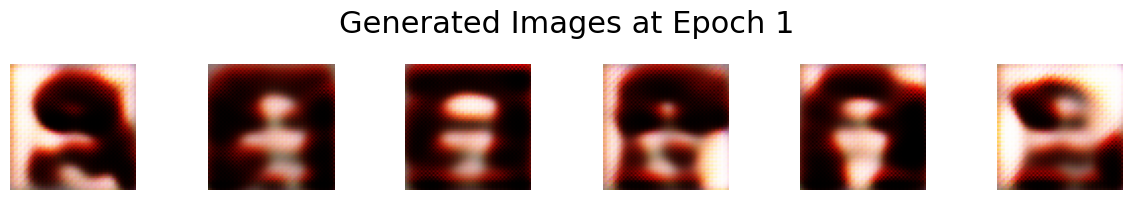

2/2 [==============================] - 0s 13ms/step


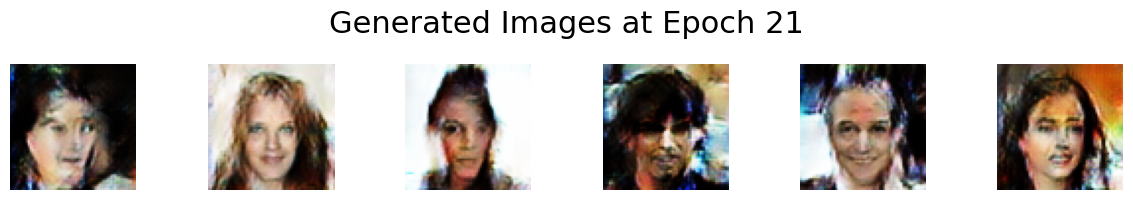

2/2 [==============================] - 0s 14ms/step


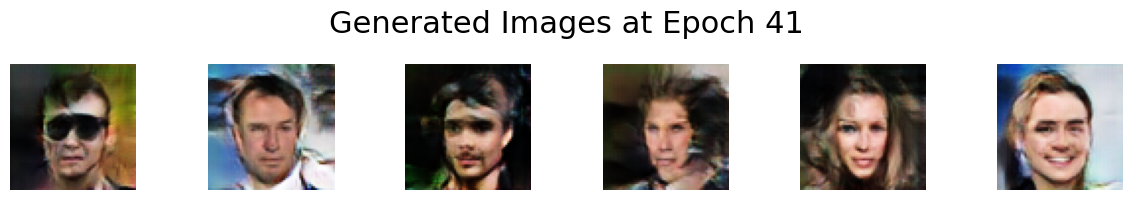

2/2 [==============================] - 0s 13ms/step


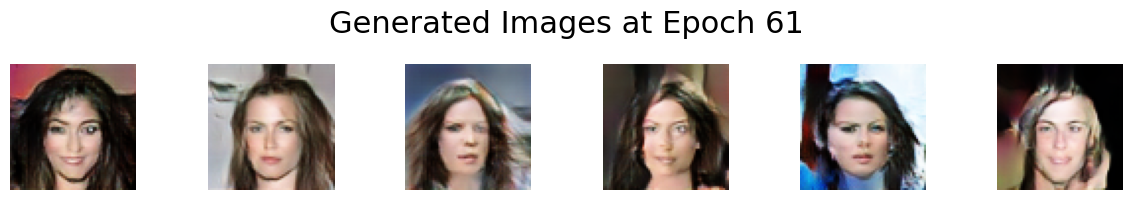

1/2 [==============>...............] - ETA: 0s

In [ ]:
# Set noise dimension for generator input
noise_dimension = 100

# Build discriminator model
discriminator = build_discriminator()

# Build generator model
generator = build_generator(noise_dimension)

# Combine generator and discriminator to form the GAN model
gan_model = build_gan(generator, discriminator)

# Train the GAN model on the dataset and get the saved images list
train(generator, discriminator, gan_model, dataset, noise_dimension, num_epochs=251, batch_size=128, display_frequency=20)